### Linear Regression the Bayesian Way

**Note that is still work in progress**

This is a simple notebook demonstrating two approaches to fitting Bayesian Linear Regression. We use a model, where we assume that the variance $\sigma^2$ of the data generating process is known.


* The Brute Force evaluation of the unnormalized posterior at all positions 
* The Bayes by Backprop approach

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline
plt.style.use('default') # No background 
plt.rcParams.update({'font.size': 15}) # Large Fonts

### Creation of data

Creation of some data and definition of parameters

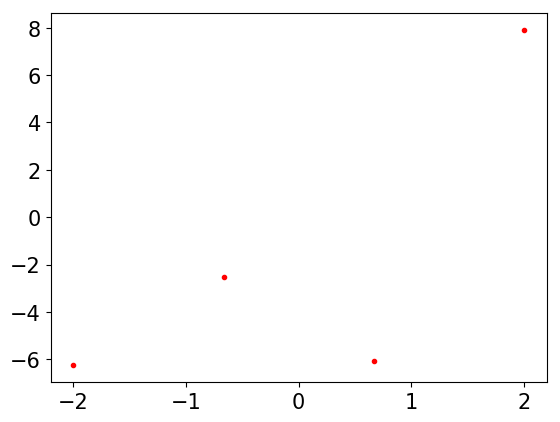

In [4]:
np.random.seed(2)
num = 4
#nbins = 30 #used to create the plots for the book (takes quite some time)
nbins = 10
bmin=-10;bmax=8
amin=-3;amax=8
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=3
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 

plt.scatter(x,y, marker='.', color='r')
plt.show()

#d = np.transpose(np.vstack((x[:,0],y)))
#np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     

### Fitting a linear model (Max Likelihood)
First fit a linear model (corresponding to the maximum likelihood approach)

In [5]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)

Coefficients a_ml:  2.9205102572725816 Coefficients b_ml -1.726712471421449


## Bayesian linear regression
We now assume the following posterior knowlegde 

1. We assume that we know the noise on the data. We can drop this assumption, however, here we want to show the different ways to fit Bayesian models. Estimating $\sigma$ is a bit more complicated, since we cannot assume a Gaussian prior.

2. We assume the following priors on the weight $a \thicksim N(0,1)$ and intercept $b \thicksim N(0,1)$

### Brute Force Bayesian

$$
    P(w|d) \thicksim \frac{P(d|w) P(w)}{P(d)} 
$$

We can calculate $P(d|w) P(w) =: \tt{unnormalized{\_}posterior}$ quite easily. For convenience we calculate the log.

In [6]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
ytensor = y.reshape([len(y),1]) #A
def log_post_unnorm(w): #B
    rv_a = tfd.Normal(loc=0., scale=1.) #C 
    rv_b = tfd.Normal(loc=0., scale=1.) #C    
    y_prob = tfd.Independent( #D
        tfd.Normal(loc=x*w[0]+w[1], scale=sigma)
    )
    return (
         tf.reduce_sum(#E
             tf.reduce_sum(y_prob.log_prob(ytensor))+
             rv_a.log_prob(w[0])+ 
             rv_b.log_prob(w[1]))
    )
#A y is now a 2-dimensional tensor
#B w holds the two random variables a=w[0] and b=w[1] in the Tensor w
#C This is the prior for the slope and intercept
#D Definition of the likelihood (independent Gaussian with fixed sigma)
#E Calculation of the log-posterior as defined in eq.log_post

### Calculation of the values for a and b correponding to the maximum posterior 

In [7]:
w = tf.Variable([[1.0],[2.0]],dtype=tf.float32) #Startvalues
for e in range(300):
    with tf.GradientTape() as tape: 
        loss = -log_post_unnorm(w)
        grads = tape.gradient(loss, w)
        w = tf.Variable(w - 0.01*grads)
a_max_post = w[0].numpy()[0]
b_max_post = w[1].numpy()[0]
print("Maximum A-Posterior a", a_max_post, " b ", b_max_post)#1.4500923  b  -0.4991095

Maximum A-Posterior a 1.4500923  b  -0.4991095


### Evaluating the posterior at some grid points
We now evaluate the unnormalized posterior on a  𝚗𝚋𝚒𝚗𝚜×𝚗𝚋𝚒𝚗  grid, ranging from  [−3,+3]  for the both the intercept and the slope. Outside this range the probability is (nearly) zero and we can use the values to normalize unpost to become a real posterior.

In [8]:
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = log_post_unnorm(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

<Figure size 600x600 with 0 Axes>

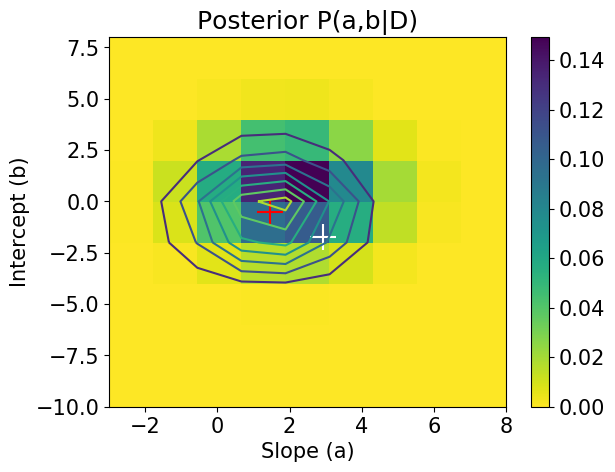

In [9]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(ai, bi, post, cmap=cmap)
plt.contour(ai, bi, post)
fig.colorbar(im, ax=ax0)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.scatter(a_max_post, b_max_post, color='r', marker='+',s=333)
plt.xlabel('Slope (a)')
plt.ylabel('Intercept (b)')
plt.title('Posterior P(a,b|D)')
plt.savefig('ch06_fblr.pdf')

### Calculation of the predictive distribution $p(y|x,(a,b))$ for fixed parameters $a,b$

We now provide a method to calculate the predictive distribution at fixed parameter values.

In [10]:
def pre_distribution(a,b):
    """
        Return the predictive distribution p(y|(a,b)) for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=sigma)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
            xi[i,j] = x_
            yi[i,j] = y_
            #canvas0[nbins_c-i-1,j] = py.prob(y_)
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, IMHO due to (more than finite) bin width this is not the case
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

### Calculation of the posteriori distribution $p(a,b|D)$

In [11]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return post[toBin(a,amin,amax),toBin(b,bmin,bmax)]

In [12]:
xmin = -10;xmax = +10;ymin=-40;ymax=40;
nbins_c=30
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in np.linspace(amin, amax, nbins): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * getProb(a,b) 
        if (b == bmin):
            print(p)

1.1188685739388575e-10
1.1525290244030997e-09
5.651261097675994e-09
1.3190549696475045e-08
1.465551629084918e-08
7.751070977059375e-09
1.951392664677472e-09
2.338563447865601e-10
1.3340594429253468e-11


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


3.6226265724060476e-13


<Figure size 600x600 with 0 Axes>

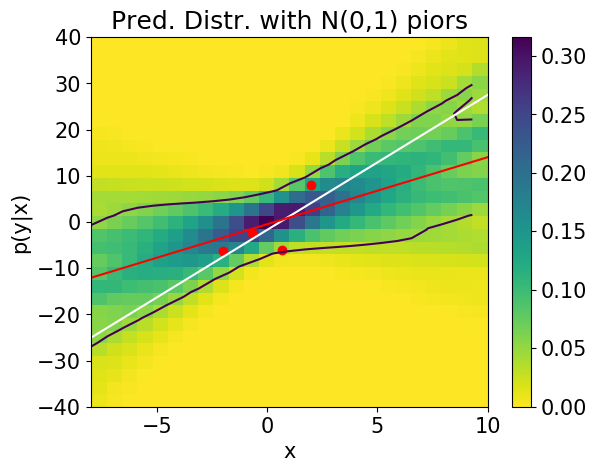

In [13]:
dumm,xi,yi = pre_distribution(a_ml,b_ml)
fig = plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[0.05])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')

plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.plot([xmin, xmax], [a_max_post*xmin+b_max_post, a_max_post*xmax+b_max_post], color='r', alpha = 1)

plt.xlim((xmin+2,xmax)) #Strange hack to avoid white space
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Pred. Distr. with N(0,1) piors')
plt.savefig('ch06_fblr_pd.pdf')

#### Shortcommings of the brute force approach
So we are done. Let's move to networks and fit the 50 million weights. 
Calculating the unnormalized posterior is easy. Done? Wait a moment. In the above example with the two weights we evaluated the unnormalized probability distribution at $\tt{nbins} \times \tt{nbins}$. If we would also fit the sigma parameter that would be $\tt{nbins}^3$ parameters. So a network with 50 million parameters would need $\tt{nbins}^{50 million}$. Let's be satisfied with only $\tt{nbins}=10$. Then we would have $10^{50'000'000}$. If you could do one billion evaluations per second, that would be still take you $10^{50'000'000}/10^9 = 10^{49'999'991}$ seconds. Even for a small network with 100 weights that would take $10^{100}/10^9 = 10^{91}$ seconds. Fun fact go type `10^100 / 10^9 seconds` into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=10%5E100+%2F+10%5E9+seconds). Solution it will take $3.169 \cdot 10^{83}$ years about 10 billion times longer than the age of the univers! [Forget it Ming!](https://getyarn.io/yarn-clip/ecb8c167-324e-4532-9a96-6b0b958fbe52)

This brute force approach does not do the trick for Bayesian Neural Networks. What next? There is an approach called Markov Chain Monte Carlo MCMC for short. It will work for small problems say 10-100 weights but not for large networks. 

### Comparing with TFP

Below a simple network with 4 hidden layers, haven 1,2,3,4 nodes each.

In [14]:
model = tf.keras.Sequential([
  tfp.layers.DenseReparameterization(1, input_shape=(None,1)),
  tfp.layers.DenseReparameterization(2),
  tfp.layers.DenseReparameterization(3)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_reparameterization (De (None, None, 1)           3         
_________________________________________________________________
dense_reparameterization_1 ( (None, None, 2)           6         
_________________________________________________________________
dense_reparameterization_2 ( (None, None, 3)           15        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#123456789012345678901234567890123456789012345678901234
def NLL(y, distr):#C
    return -distr.log_prob(y) 
    
def my_dist(mu): #C
    return tfd.Normal(loc=mu[:,0:1], scale=sigma)

divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0) #B


model = tf.keras.Sequential([
    tfp.layers.DenseReparameterization(1,
       kernel_divergence_fn=divergence_fn,
       bias_divergence_fn=divergence_fn, #A
       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn()#A
                                       ),
    tfp.layers.DistributionLambda(my_dist)
])


sgd = tf.keras.optimizers.SGD(lr=.005)
model.compile(loss=NLL, optimizer=sgd)

# A note that TFP usually does not assume distributions on the weights, we overwrite this here. 
# B Rescaling KL-divergence term. Kind of Bug fix for TFP
# C The usual NLL loss for a Gaussian Distribution with fixed variance 

In [16]:
# Strange Bug with current TFP version.  
# This code does not run when replaceing the upper cell
# #123456789012345678901234567890123456789012345678901234
# def NLL(y, distr):#C
#     return -distr.log_prob(y) 
    
# def my_dist(mu): #C
#     return tfd.Normal(loc=mu[:,0:1], scale=sigma)

# divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0) #B

# normal = tfp.layers.util.default_multivariate_normal_fn   
# x_ = Input(shape=(1,))
# mu = tfp.layers.DenseReparameterization(1,
#        kernel_divergence_fn=divergence_fn,#B
#        bias_divergence_fn=divergence_fn, #B
#        bias_prior_fn=normal,#A
#        bias_posterior_fn=normal#A
#     )(x_)

# dist = tfp.layers.DistributionLambda(my_dist)(mu) #C 

# model = Model(inputs=x_, outputs=dist)
# sgd = tf.keras.optimizers.SGD(lr=.005)
# model.compile(loss=NLL, optimizer=sgd)

Text(0, 0.5, 'Total loss')

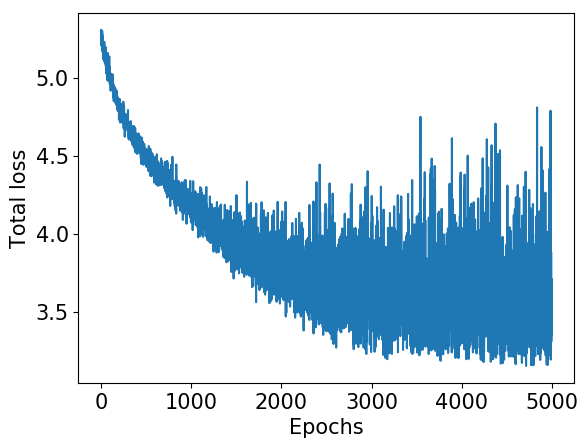

In [17]:
hist = model.fit(x, y, epochs=5000, batch_size=num, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')

In [18]:
# print("Loss handwritten ", np.min((loss_history[-100:] / num)), 
#       "TF ", np.min(hist.history['loss'][-100:]))
import pandas as pd
def sp(x):
    return np.log(1 + np.exp(x))**2

w = model.get_weights()
pd.DataFrame({
    'TFP ':[w[0][0,0], sp(w[1][[0]])[0,0],w[2][0], sp(w[3][[0]])[0]], 
    #'VI Manual ': [a_m, cov_var[0,0], b_m, cov_var[1,1]], 
    'MaxLike':[a_ml[0], '-', b_ml, '-'], 
    'MaxPost':[a_max_post, '-', b_max_post, '-']}, 
    #'MCMC':[a_locmcmc, cov_mcmc[0,0], b_locmcmc, cov_mcmc[1,1]]},
    index=['a_loc','a_var','b_loc','b_var']
)

,MaxLike,MaxPost,TFP
a_loc,2.92051,1.45009,1.448390
a_var,-,-,0.492703
b_loc,-1.72671,-0.49911,-0.535326
b_var,-,-,0.642254
